<a href="https://colab.research.google.com/github/fnavab/APS360-project/blob/main/holdout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_ALEX(nn.Module):
    def __init__(self):
        super(CNN_ALEX, self).__init__()
        self.name="CNN_ALEX"
        # self.conv = nn.Conv2d(256, 10, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv(x)))

        x = x.view(x.shape[0], 256 * 8 * 8) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [21]:
def get_alex_data_loader(batch_size):
  train_dir = '/content/gdrive/My Drive/Colab Notebooks/combined_features/train'
  test_dir = '/content/gdrive/My Drive/Colab Notebooks/combined_features/test'
  val_dir = '/content/gdrive/My Drive/Colab Notebooks/combined_features/val'
  train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.tensor'))
  val_set= torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.tensor'))
  test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.tensor'))
  torch.manual_seed(1) # set the random seed

  num_workers = 1
  train_feature_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  test_feature_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  val_feature_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)


  return train_feature_loader, test_feature_loader,val_feature_loader

In [22]:
#Prepare feature loader
train_feature_loader, test_feature_loader,val_feature_loader=get_alex_data_loader(64)

In [6]:
#Prepare feature loader
dir = '/content/gdrive/My Drive/Colab Notebooks/APS360 GROUP/holdout_features'
holdout_set = torchvision.datasets.DatasetFolder(dir, loader=torch.load, extensions=('.tensor'))

holdout_feature_loader = torch.utils.data.DataLoader(holdout_set, batch_size=64, 
                                            shuffle=True)

In [7]:
len(holdout_set)

4224

In [46]:
# Verification Step - obtain one batch of features
dataiter = iter(holdout_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

torch.Size([64, 256, 8, 8])
torch.Size([64])


In [8]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

TO DO: Hyper parameter tuning

In [9]:
model=CNN_ALEX()
model.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/Final-Model"))


<All keys matched successfully>

In [10]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
get_accuracy(model,holdout_feature_loader)

0.7111742424242424

In [23]:
get_accuracy(model,test_feature_loader)

0.8356573705179283

In [13]:
def get_confusion_matrix(model, data_loader):
    correct = 0
    total = 0
    nb_classes = 8

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():

      for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        
        for t, p in zip(labels.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    # # Visualize it as a heatmap
    import seaborn
    seaborn.heatmap(confusion_matrix)
    plt.show()

tensor([[440.,  17.,   3.,   5.,  21.,   0.,  16.,  26.],
        [ 25., 391.,   2.,   3.,  34.,   2.,  10.,  61.],
        [  5.,   4., 383., 116.,   0.,  14.,   5.,   1.],
        [  5.,  11.,  89., 369.,   4.,  22.,  22.,   6.],
        [ 20.,  47.,   5.,   8., 359.,   6.,  12.,  71.],
        [  2.,  16.,  16.,  23.,  11., 348., 107.,   5.],
        [ 11.,   9.,  20.,  22.,  10.,  55., 387.,  14.],
        [ 13.,  91.,   2.,   5.,  68.,   6.,  16., 327.]])
tensor([0.8333, 0.7405, 0.7254, 0.6989, 0.6799, 0.6591, 0.7330, 0.6193])


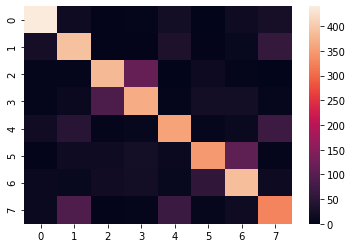

In [14]:
get_confusion_matrix(model,holdout_feature_loader)